Logistic Regression - Accuracy: 0.8729
Logistic Regression - Confusion Matrix:
[[126   0   2   0   0   2   3   0   0   0]
 [  0 161   0   0   0   2   0   1   1   1]
 [  2   4 112   7   3   1   4   3   4   0]
 [  0   2   6 116   1   8   0   4   6   3]
 [  0   1   4   0  94   1   1   2   0   5]
 [  4   0   2  11   3 102   2   0   6   2]
 [  0   1   2   1   3   1 149   0   1   0]
 [  0   0   2   2   0   0   0 132   0   4]
 [  2   3   1   7   1  10   1   0 114   3]
 [  1   1   0   0   9   0   0   7   1 116]]

SVM - Accuracy: 0.9229
SVM - Confusion Matrix:
[[129   0   0   0   0   0   3   0   0   1]
 [  0 164   1   0   0   0   0   1   0   0]
 [  0   0 130   3   0   0   3   2   2   0]
 [  0   0   4 131   0   4   1   3   2   1]
 [  0   1   5   0  93   0   0   2   0   7]
 [  1   0   3   5   1 118   0   1   2   1]
 [  0   0   7   0   1   2 147   0   1   0]
 [  0   0   5   0   0   0   0 130   1   4]
 [  0   2   2   4   1   5   1   0 127   0]
 [  0   0   2   0   5   0   0   4   1 123]]

Random For

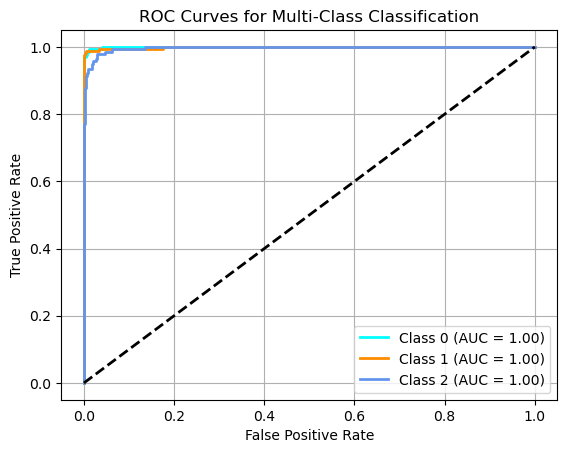

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  19.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  20.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  28.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  22.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  19.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   7.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   8.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   9.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   8.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   8.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   8.0s
[CV] END .....................C=0.1, gamma=1, k

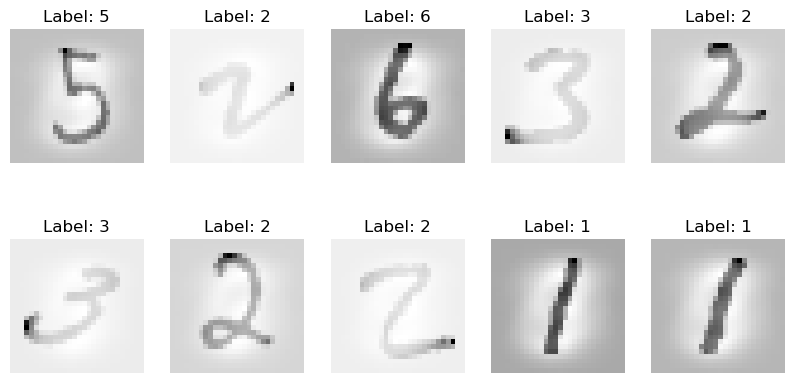

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Загрузка данных MNIST
mnist_data = fetch_openml('mnist_784', version=1, as_frame=False)
data, labels = mnist_data["data"], mnist_data["target"].astype(int)

# Создаем DataFrame и отбираем подвыборку
mnist_df = pd.DataFrame(data)
mnist_df['label'] = labels
sampled_df = mnist_df.sample(frac=0.1, random_state=42)

X_sampled = sampled_df.drop('label', axis=1)
y_sampled = sampled_df['label']

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sampled)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sampled, test_size=0.2, random_state=42)

# Инициализация и обучение моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, alpha=1e-4,
                                      solver='sgd', random_state=42, learning_rate_init=0.1)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

# Оценка моделей
for model_name, model in models.items():
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Confusion Matrix:\n{confusion}\n")

# Построение ROC-кривых
binarized_labels = label_binarize(y_test, classes=np.unique(y_test))
num_classes = binarized_labels.shape[1]

multi_svc = SVC(probability=True)
multi_svc.fit(X_train, y_train)
predicted_scores = multi_svc.predict_proba(X_test)

roc_data = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], predicted_scores[:, i])
    roc_data[i] = (fpr, tpr, auc(fpr, tpr))

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in enumerate(colors[:num_classes]):
    fpr, tpr, roc_auc = roc_data[i]
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Гиперпараметрическая оптимизация
svc_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc_grid_search = GridSearchCV(SVC(), svc_params, verbose=2, refit=True)
svc_grid_search.fit(X_train, y_train)
print("Best GridSearch Parameters:", svc_grid_search.best_params_)
print("Best GridSearch Score:", svc_grid_search.best_score_)

svc_random_search = RandomizedSearchCV(SVC(), param_distributions={
    'C': np.logspace(-3, 2, 6),
    'gamma': np.logspace(-3, 2, 6),
    'kernel': ['rbf', 'poly', 'sigmoid']
}, n_iter=50, random_state=42, verbose=2, refit=True)

svc_random_search.fit(X_train, y_train)
print("Best RandomSearch Parameters:", svc_random_search.best_params_)
print("Best RandomSearch Score:", svc_random_search.best_score_)

# Визуализация первых 10 изображений тестового набора
def show_digit(image_data):
    plt.imshow(image_data.reshape(28, 28), cmap='binary')
    plt.axis('off')

plt.figure(figsize=(10, 5))
for idx, (image, label) in enumerate(zip(X_test[:10], y_test[:10])):
    plt.subplot(2, 5, idx + 1)
    show_digit(image)
    plt.title(f"Label: {label}")
plt.show()

# Важность признаков из случайного леса
feature_importances = models["Random Forest"].feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

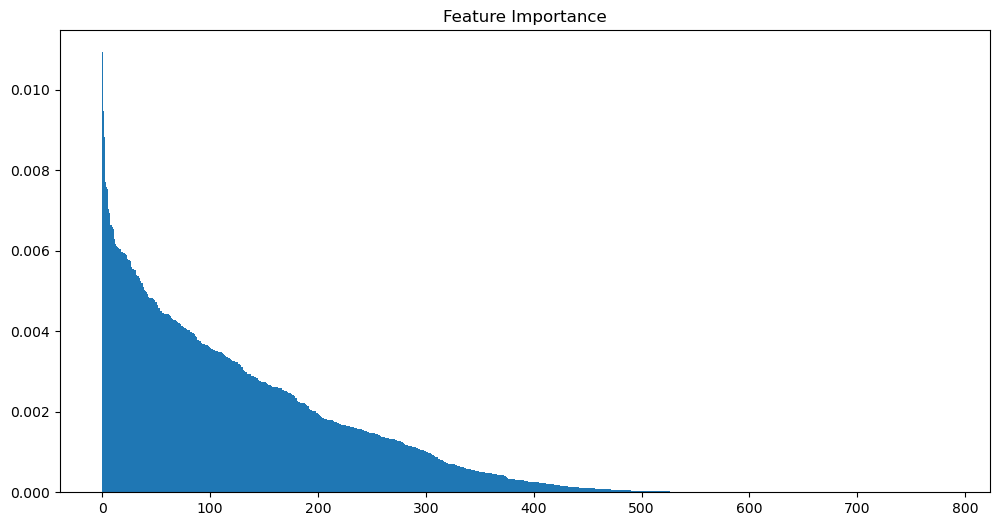

In [2]:
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center", width=1)
plt.show()